In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from io import StringIO
from glob import glob
import wandb
%matplotlib inline

In [2]:
their_data = """1 | 0.512 (0.434,0.593) | 1.18 (1.137,1.220)
2 | 0.604(0.589,0.620) |1.10(1.044,1.153)
3 | 0.624(0.617,0.632)|1.06(1.015,1.103)
4 | 0.602(0.520,0.684)|1.045(0.988,1.101)
5 | 0.623(0.614,0.636)|1.03(0.960,1.107)
6 | 0.636(0.628,0.647)|1.042(0.937,1.147)"""
their_data = their_data.replace(' ','').replace('|',',').replace('(',',').replace(')',',').replace(',,',',')
their_df = pd.read_csv(StringIO(their_data),sep=',',header=None)
their_df.columns = ['Addnl Ligs','R','R_stdl','R_stdg','RMSE','RMSE_stdl','RMSE_stdg','bad']
del their_df['bad']

In [3]:
their_df['R_std'] = (their_df['R']-their_df['R_stdl'])+(their_df['R_stdg']-their_df['R'])/2
their_df['RMSE_std'] = (their_df['RMSE']-their_df['RMSE_stdl'])+(their_df['RMSE_stdg']-their_df['RMSE'])/2

In [4]:
# Pulling this data from W&B Report
my_data_list = [[1,0.5328,0.03314,1.134,0.0379],
               [2,0.6499,0.01873,0.9712,0.02487],
               [3,0.7026,0.01578,0.8981,0.02793],
               [4,0.734,0.01361,0.8504,0.02235],
               [5,0.758,0.01064,0.8127,0.01831],
               [6,0.7758,0.01302,0.7829,0.02375]]
my_df = pd.DataFrame(my_data_list,columns=['Addnl Ligs','R','R_std','RMSE','RMSE_std'])

In [5]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


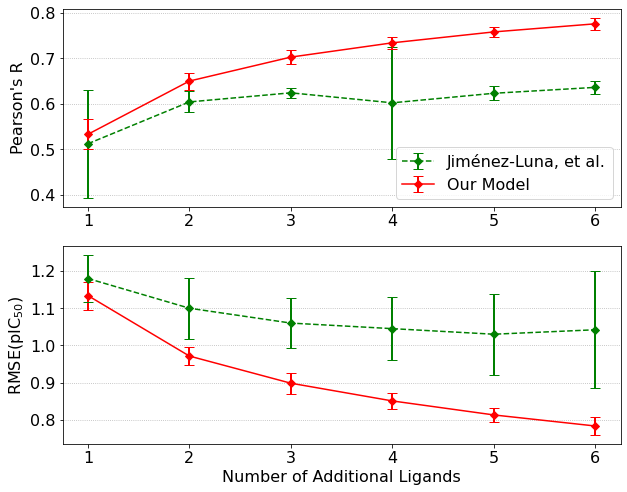

In [6]:
plt.figure(figsize=(10,8))
plt.subplot(211)
plt.errorbar(their_df['Addnl Ligs'],their_df['R'],yerr=their_df['R_std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(my_df['Addnl Ligs'],my_df['R'],yerr=my_df['R_std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.ylabel("Pearson's R")
plt.legend()
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
plt.subplot(212)
plt.errorbar(their_df['Addnl Ligs'],their_df['RMSE'],yerr=their_df['RMSE_std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.errorbar(my_df['Addnl Ligs'],my_df['RMSE'],yerr=my_df['RMSE_std'],label='ours',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
plt.xlabel('Number of Additional Ligands')
plt.ylabel("RMSE(pIC$_{50}$)")
ax = plt.gca()
ax.grid(axis='y',linestyle=':')
# plt.savefig('paper_comparison_both.png',dpi=500)

In [7]:
paper_values = dict()
for filename in glob('external_test/*/Paper_*_R*.csv'):
    testset = filename.split('/')[1]
    measure = filename.split('_')[-1].split('.')[0]
    raw = pd.read_csv(filename,header=None)
    raw.columns = ['x','y']
    raw = raw.round({'x':0,'y':3})
    raw['x'] = raw['x'].abs()
    sorted_groupby = raw.sort_values(by=['x','y']).groupby('x')
    final = sorted_groupby.nth(1)
    final['std'] = (sorted_groupby.nth(2)-sorted_groupby.nth(0))/2
    if testset not in paper_values:
        paper_values[testset] = dict()
    paper_values[testset][measure] = final
paper_values.keys()

dict_keys(['Thrombin', 'P38', 'BACE', 'JNK1', 'PTP1B', 'CDK2', 'BRD4', 'MCL1', 'TYK2'])

In [11]:
external_dataset_measures=['Thrombin.Test RMSE','Thrombin.Test R','P38.Test RMSE','P38.Test R','BACE.Test RMSE',
                           'BACE.Test R','JNK1.Test RMSE','JNK1.Test R','PTP1B.Test RMSE','PTP1B.Test R',
                           'CDK2.Test RMSE','CDK2.Test R','BRD4.Test RMSE','BRD4.Test R','MCL1.Test RMSE',
                           'MCL1.Test R','TYK2.Test RMSE','TYK2.Test R']
pub_api = wandb.apis.public.Api()
runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
             filters={"$and":[{"config.use_model":'multtask_latent_def2018'},{'config.trainfile':'all_newdata.types'},
                             {"config.dropout":int(0)},{"config.stratify_rec":False},{"config.eval":True},{"state":"finished"}]})
our_data = pd.DataFrame(columns=external_dataset_measures)
for run in runs:
#     print(run)
    new_row = pd.DataFrame.from_dict(run.history(keys=external_dataset_measures,pandas=False)[0][0],orient='index').T
    our_data = our_data.append(new_row,ignore_index=True)

In [12]:
final_data = pd.concat([our_data.mean(axis=0),our_data.std(axis=0)],axis=1)
final_data.columns = ['mean','std']

In [13]:
import os.path 
def get_finetune(testset,finetune_fname='finetune'):
    values = dict()
    new_set = None
    fname = f'external_test/{testset}/{testset}_{finetune_fname}.txt'
    if not os.path.isfile(fname):
        return None
    with open(fname) as finet:
        for line in finet:
            if 'train' in line:
                if new_set:
                    values[addnl_ligs] = new_set
                addnl_ligs = line.split('_')[-1].split('.')[0]
            elif 'test' in line:
                aware = True
            elif 'DDG' in line and aware:
                new_set = line.strip().split(',')[1:-1]
                aware = False
    values[addnl_ligs] = new_set
    
    values_df = pd.DataFrame(values,dtype='float64').T
    values_df.columns=['Avg R','Stddev R','useless','Avg RMSE','Stddev RMSE']
    return values_df.sort_index()


In [14]:
import numpy as np

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


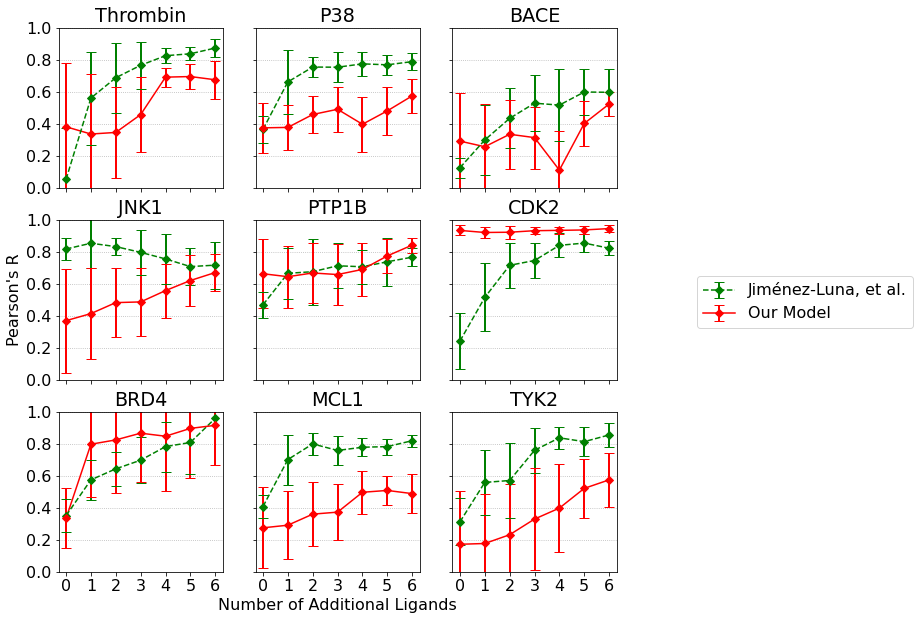

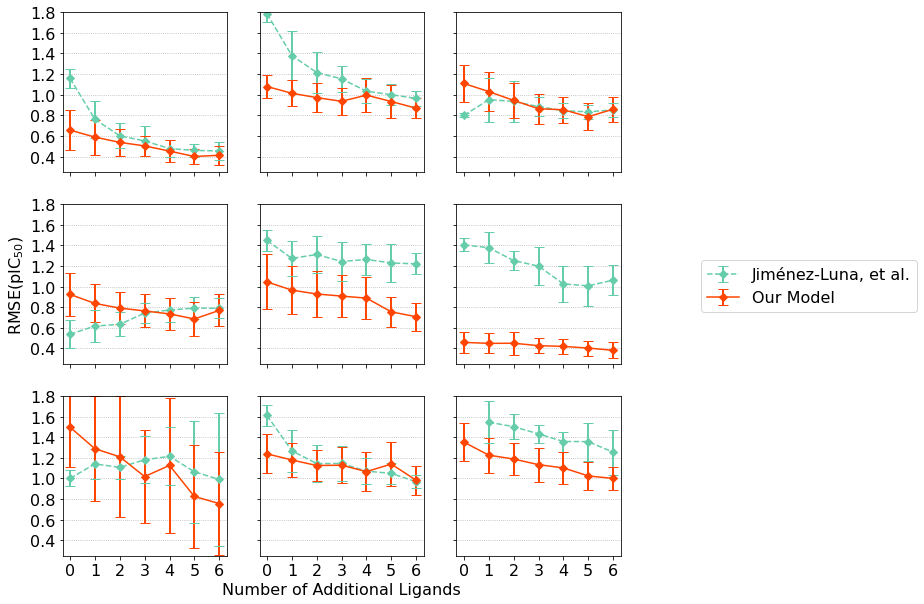

In [15]:
rfig, raxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
rmsefig, rmseaxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
for idx, test_set in enumerate(paper_values.keys()):
    val = [idx // 3, idx % 3]
    finetune_df = get_finetune(test_set)
    raxes[val[0],val[1]].set_title(test_set)
    theirs = raxes[val[0],val[1]].errorbar(paper_values[test_set]['R'].index,paper_values[test_set]['R']['y'],yerr=paper_values[test_set]['R']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    ours = raxes[val[0],val[1]].errorbar(0,final_data.loc[f'{test_set}.Test R','mean'],yerr=final_data.loc[f'{test_set}.Test R','std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    if finetune_df is not None:
        raxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg R'],yerr=finetune_df['Stddev R'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        raxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test R','mean']),float(finetune_df.loc['1','Avg R'])],c='r')
    if val[1] == 0 and val[0] == 1:
        raxes[val[0],val[1]].set_ylabel("Pearson's R")
    if val[0] == 2 and val[1] == 1:
        raxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
#     raxes[val[0],val[1]].legend()
#     ax = plt.gca()
    
    raxes[val[0],val[1]].set_ylim(bottom=0,top=1)
    raxes[val[0],val[1]].locator_params(axis='both',nbins=7)
    raxes[val[0],val[1]].grid(axis='y',linestyle=':')
    if val[0] == 2 and val[1] == 2:
        r_leg = rfig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
    theirs= rmseaxes[val[0],val[1]].errorbar(paper_values[test_set]['RMSE'].index,paper_values[test_set]['RMSE']['y'],yerr=paper_values[test_set]['RMSE']['std'],label='Jiménez-Luna, et al.',c='mediumaquamarine',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    ours = rmseaxes[val[0],val[1]].errorbar(0,final_data.loc[f'{test_set}.Test RMSE','mean'],yerr=final_data.loc[f'{test_set}.Test RMSE','std'],label='Our Model',c='orangered',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
    if finetune_df is not None:
        rmseaxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg RMSE'],yerr=finetune_df['Stddev RMSE'],c='orangered',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        rmseaxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test RMSE','mean']),float(finetune_df.loc['1','Avg RMSE'])],c='orangered')
    if val[0] == 2 and val[1] == 1:
        rmseaxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
    if val[1] == 0 and val[0] == 1:
        rmseaxes[val[0],val[1]].set_ylabel("RMSE(pIC$_{50}$)")
    if val[0] == 2 and val[1] == 2:
        rmse_leg = rmsefig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
    rmseaxes[val[0],val[1]].grid(axis='y',linestyle=':')
    rmseaxes[val[0],val[1]].set_ylim(bottom=0.25,top=1.8)
    rmseaxes[val[0],val[1]].locator_params(axis='both',nbins=8)
rfig.savefig('external_test/external_test_R.png',bbox_inches='tight',transparent=False)
rmsefig.savefig('external_test/external_test_RMSE.png',bbox_inches='tight',transparent=False)

In [17]:
def get_paper_compare(use_model,dropout,strat_rec,finetune_fname):
    if dropout == 0:
        dropout = int(dropout)
    runs = pub_api.runs(path='andmcnutt/DDG_model_Regression',
             filters={"$and":[{"config.use_model":use_model},{'config.trainfile':'all_newdata.types'},
                             {"config.dropout":dropout},{"config.stratify_rec":strat_rec},{"config.eval":True},{"state":"finished"}]})
    our_data = pd.DataFrame(columns=external_dataset_measures)
    for run in runs:
    #     print(run)
        new_row = pd.DataFrame.from_dict(run.history(keys=external_dataset_measures,pandas=False)[0][0],orient='index').T
        our_data = our_data.append(new_row,ignore_index=True)
    final_data = pd.concat([our_data.mean(axis=0),our_data.std(axis=0)],axis=1)
    final_data.columns = ['mean','std']
    rfig, raxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
    rmsefig, rmseaxes = plt.subplots(ncols=3,nrows=3,figsize=(10,10),sharex=True,sharey=True)
    for idx, test_set in enumerate(paper_values.keys()):
        val = [idx // 3, idx % 3]
        finetune_df = get_finetune(test_set,finetune_fname)
        raxes[val[0],val[1]].set_title(test_set)
        theirs = raxes[val[0],val[1]].errorbar(paper_values[test_set]['R'].index,paper_values[test_set]['R']['y'],yerr=paper_values[test_set]['R']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        ours = raxes[val[0],val[1]].errorbar(0,final_data.loc[f'{test_set}.Test R','mean'],yerr=final_data.loc[f'{test_set}.Test R','std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        if finetune_df is not None:
            raxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg R'],yerr=finetune_df['Stddev R'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
            raxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test R','mean']),float(finetune_df.loc['1','Avg R'])],c='r')
        if val[1] == 0 and val[0] == 1:
            raxes[val[0],val[1]].set_ylabel("Pearson's R")
        if val[0] == 2 and val[1] == 1:
            raxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
    #     raxes[val[0],val[1]].legend()
    #     ax = plt.gca()

        raxes[val[0],val[1]].set_ylim(bottom=0,top=1)
        raxes[val[0],val[1]].locator_params(axis='both',nbins=7)
        raxes[val[0],val[1]].grid(axis='y',linestyle=':')
        if val[0] == 2 and val[1] == 2:
            r_leg = rfig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
        
        rmseaxes[val[0],val[1]].set_title(test_set)
        theirs= rmseaxes[val[0],val[1]].errorbar(paper_values[test_set]['RMSE'].index,paper_values[test_set]['RMSE']['y'],yerr=paper_values[test_set]['RMSE']['std'],label='Jiménez-Luna, et al.',c='g',linestyle='--',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        ours = rmseaxes[val[0],val[1]].errorbar(0,final_data.loc[f'{test_set}.Test RMSE','mean'],yerr=final_data.loc[f'{test_set}.Test RMSE','std'],label='Our Model',c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
        if finetune_df is not None:
            rmseaxes[val[0],val[1]].errorbar([int(val) for val in finetune_df.index.tolist()],finetune_df['Avg RMSE'],yerr=finetune_df['Stddev RMSE'],c='r',markeredgewidth=1,capsize=5,elinewidth=2,marker='D')
            rmseaxes[val[0],val[1]].plot([0,1],[float(final_data.loc[f'{test_set}.Test RMSE','mean']),float(finetune_df.loc['1','Avg RMSE'])],c='r')
        if val[0] == 2 and val[1] == 1:
            rmseaxes[val[0],val[1]].set_xlabel('Number of Additional Ligands')
        if val[1] == 0 and val[0] == 1:
            rmseaxes[val[0],val[1]].set_ylabel("RMSE(pIC$_{50}$)")
        if val[0] == 2 and val[1] == 2:
            rmse_leg = rmsefig.legend([theirs,ours],['Jiménez-Luna, et al.','Our Model'],loc='center left',bbox_to_anchor=(1, 0.5))
        rmseaxes[val[0],val[1]].grid(axis='y',linestyle=':')
        rmseaxes[val[0],val[1]].set_ylim(bottom=0.25,top=1.8)
        rmseaxes[val[0],val[1]].locator_params(axis='both',nbins=8)
#     rfig.savefig('external_test/external_test_R.png',bbox_inches='tight',transparent=False)
#     rmsefig.savefig('external_test/external_test_RMSE.png',bbox_inches='tight',transparent=False)

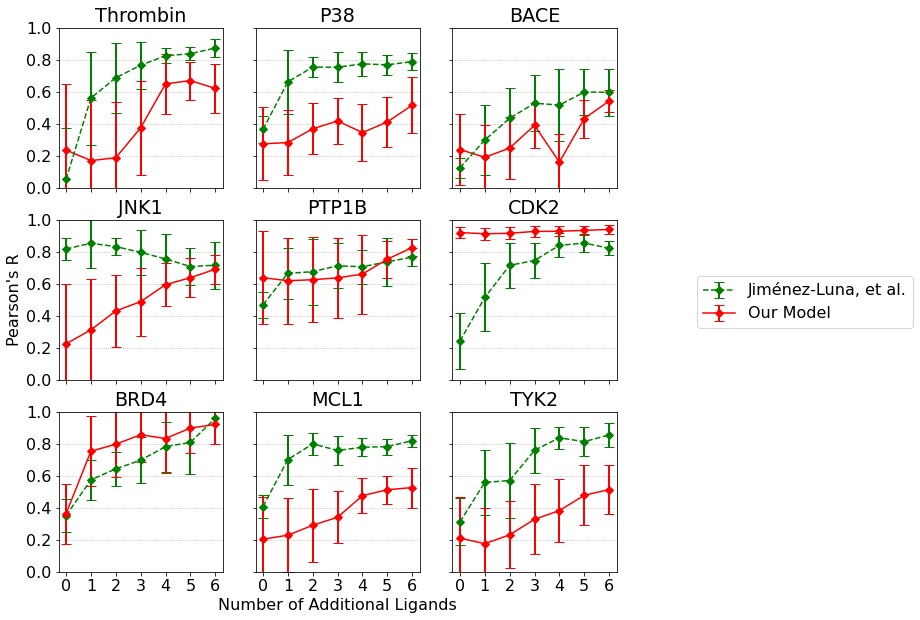

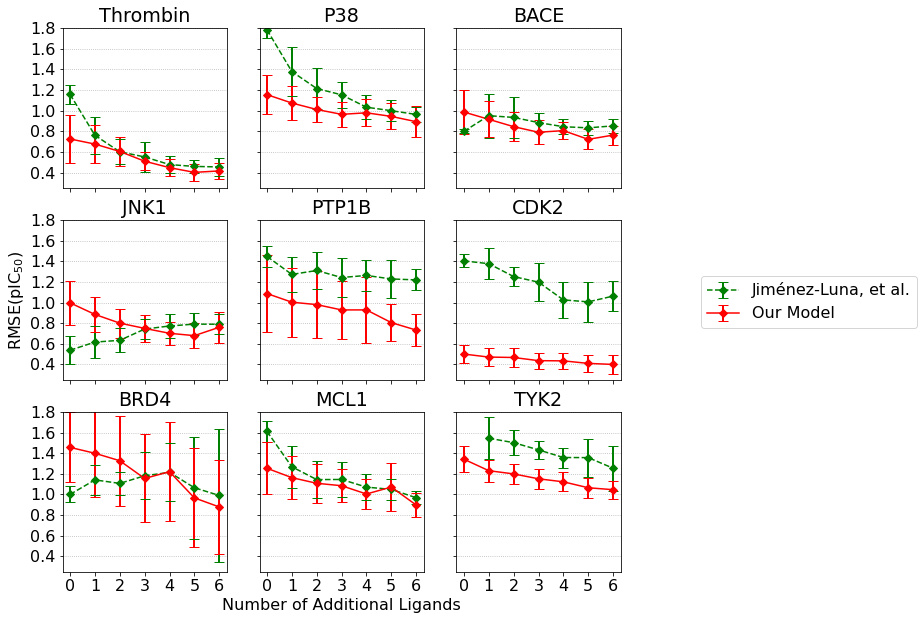

In [18]:
get_paper_compare('multtask_latent_def2018',0.5,False,'finetune_D5')

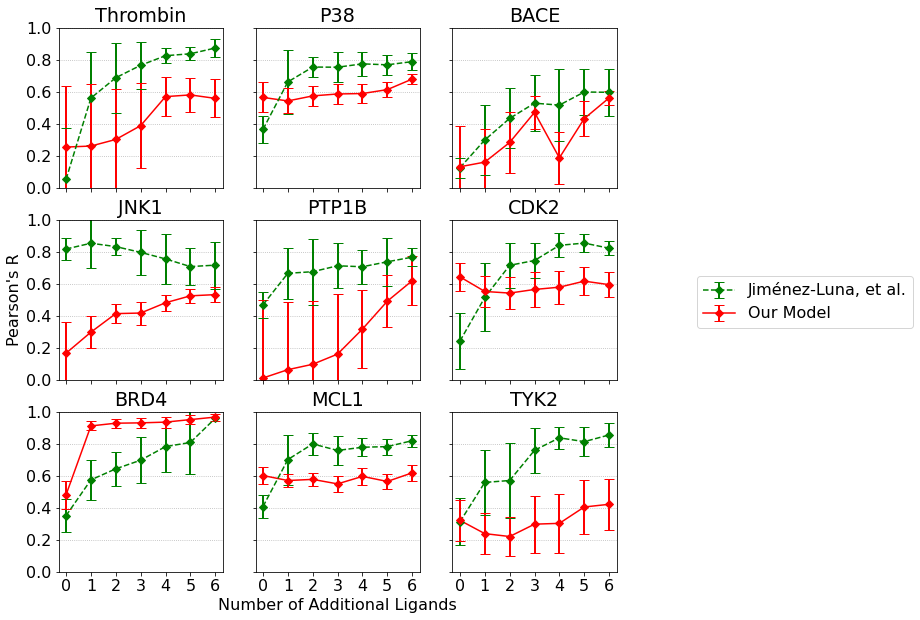

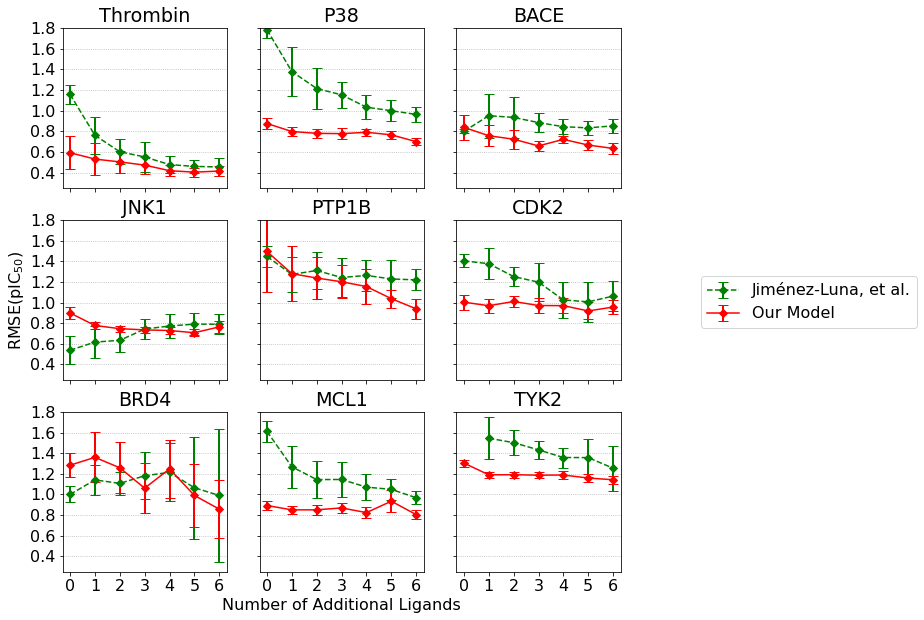

In [19]:
get_paper_compare('multtask_latent_def2018',0.5,True,'finetune_D5_SR')

/home/anm329/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


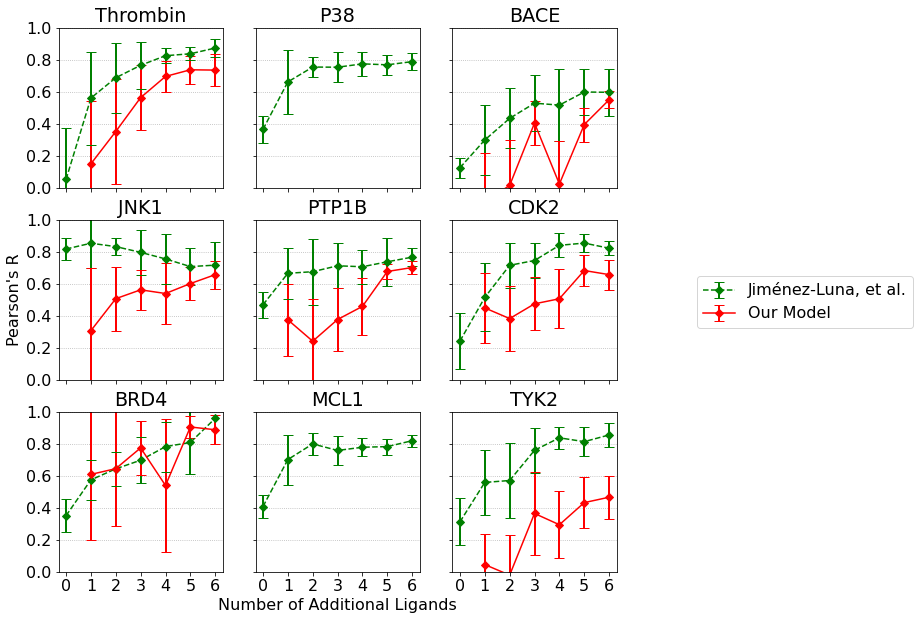

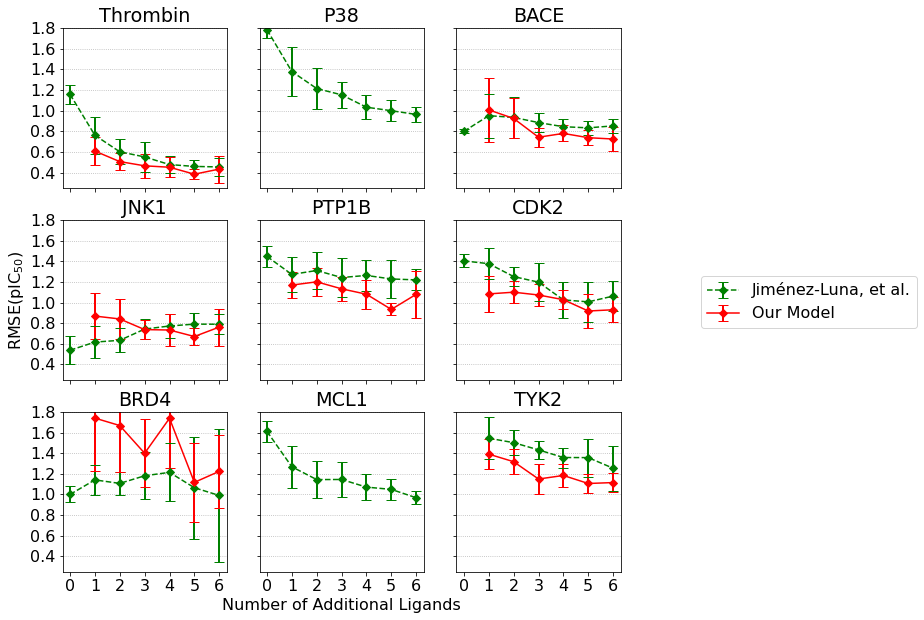

In [20]:
get_paper_compare('multtask_latent_def2018_concat',0,True,'finetune_concat_SR')